In [1]:
import pandas as pd 
import numpy as np
import matplotlib
%matplotlib inline 
import matplotlib.pyplot as plt
import seaborn as sns 
from sklearn import preprocessing 
#!pip install folium
#!pip install geopy
from geopy.distance import great_circle
# Modeling
from sklearn.base import BaseEstimator
from sklearn.ensemble import GradientBoostingRegressor

In [2]:
df = pd.read_csv(r"sensor_df.csv")
df.head()

,timestamp,value,lat,lon,device_ID
0,2019-10-25 17:19:04.000,10.10,37.760821,-122.497421,649046
1,2019-10-25 21:29:04.000,17.22,37.760821,-122.497421,649046
2,2019-10-25 00:01:04.000,11.13,37.760821,-122.497421,649046
3,2019-10-25 16:31:13.000,0.44,37.783034,-122.408106,377964
4,2019-10-25 11:13:13.000,0.02,37.783034,-122.408106,377964


In [3]:
byID = df.sort_values(by = 'device_ID')

#how many devices are there?
print ('There are',len(byID['device_ID'].unique()),'sensors.')
print ('There are',len(byID['lat'].unique()),'unique latitudes.')
print ('There are',len(byID['lon'].unique()),'unique longitudes.')

There are 112 sensors.
There are 116 unique latitudes.
There are 117 unique longitudes.


Assusming the sensors are menat to be stationary during the sampling period, how far did the sensors that don't have constant coordinates move?

In [4]:
devices = df.groupby(['lat','lon','device_ID']).size().reset_index().rename(columns={0:'count'})
devices.head()

,lat,lon,device_ID,count
0,37.715385,-122.475713,327882,22111
1,37.719936,-122.429865,554084,10591
2,37.722379,-122.439150,302620,13953
3,37.722383,-122.439227,325944,18192
4,37.722391,-122.439180,287558,11588


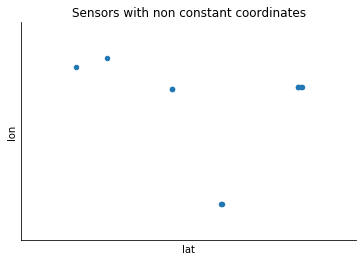

In [5]:
#visualize nonstationary sensor distribution 

devices_ns = devices[devices.duplicated('device_ID', False)]

scatter_plot = devices_ns.plot.scatter(x='lat', 
               y='lon')

scatter_plot.set_yticklabels([])
scatter_plot.set_xticklabels([])
scatter_plot.set_xticks([])
scatter_plot.set_yticks([])
scatter_plot.spines['top'].set_color(None)
scatter_plot.spines['right'].set_color(None)
plt.xlabel('lat')
plt.ylabel('lon')
scatter_plot.set_title('Sensors with non constant coordinates')

scatter_plot.set_yticklabels(labels = 'Latitude', fontdict={'fontsize': 20})
plt.show()

Of the sensors that has differinf coordiates throughout the sampling period, the locations were not signifcantly changed. Where are the sensors located relative to one another, and what is the magnitude of the value being measured?

In [6]:
#visualize locations of all sensors 
import folium
device_locations = df.groupby('device_ID').mean()
device_locations.reset_index(inplace = True)

mlat = device_locations.lat.mean()
mlng = device_locations.lon.mean()

target = [37.76595, -122.39902]

sf_map = folium.Map(location=[mlat, mlng], zoom_start = 13)

for device in device_locations.itertuples():
    label = ('Device: {}, Mean {}').format(device[1], device[2])
    
    folium.Circle(radius=device[2]*1.5, 
                  popup=label, 
                  location=[device[3], device[4]], 
                  color = 'red', 
                  fill=True,
                  fill_opacity=0.7).add_to(sf_map) 
    folium.Circle(radius = 100,
                  location = target,
                  popup = 'Target Location',
                  color = 'green',
                  fill = True).add_to(sf_map)

sf_map

#### Immediate insights from map: 
Target Locations is is a minimum of 5 blocks from the nearest sensor. It is also on a main street with higher traffic. There also seem to be outliers in the data (for example, 382894). This sensor is in the vicinity of other sensors that do not share this high value. The time series for this sensor will be plotted to determine if this is due to one single high value or if values during that time period are truly that high, outlying values will be imputed with a rolling average.

(array([    0.,  2500.,  5000.,  7500., 10000., 12500., 15000., 17500.,
        20000., 22500.]), <a list of 10 Text xticklabel objects>)

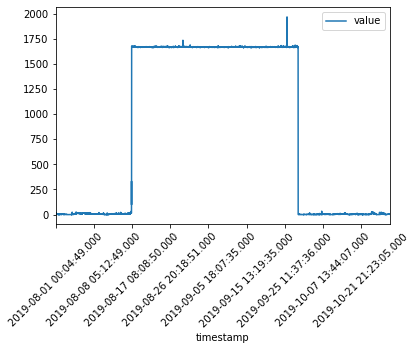

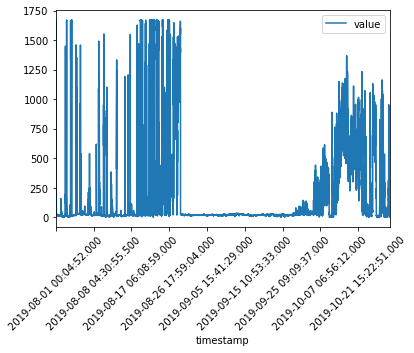

In [7]:
df.sort_values(['device_ID','timestamp'], inplace = True)
df_outlier = df[df['device_ID'] == 382894]
df_outlier.plot('timestamp', 'value')
plt.xticks(rotation = 45)

df_outlier2 = df[df['device_ID'] == 390816]
df_outlier2.plot('timestamp', 'value')
plt.xticks(rotation = 45)

In [8]:
#Determine Outlier Threshold. Threshold is set at mean + 1 std becuase the magnitude of outliers is skewing the standard deviation. 
mean = df.value.mean()
std = df.value.std()
threshold = mean + std
outliers = df.groupby('device_ID').mean()
outliers = outliers[outliers['value']> threshold]

In [9]:
#Replace Outliers with rolling mean
df.loc[df['value'] > threshold] = np.nan
df.value = df.value.fillna(df.value.rolling(10).mean())

(array([    0.,  2000.,  4000.,  6000.,  8000., 10000., 12000., 14000.,
        16000., 18000.]), <a list of 10 Text xticklabel objects>)

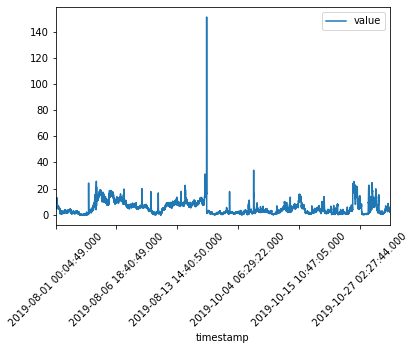

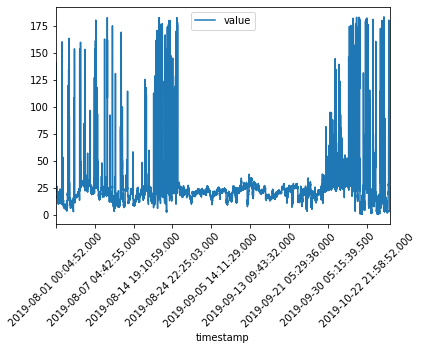

In [10]:
df_outlier1 = df[df['device_ID'] == 382894]
df_outlier1.plot('timestamp', 'value')
plt.xticks(rotation = 45)

df_outlier2 = df[df['device_ID'] == 390816]
df_outlier2.plot('timestamp', 'value')
plt.xticks(rotation = 45)

In [11]:
#visualize locations of all sensors with outliers replaced 
device_locations = df.groupby('device_ID').mean()
device_locations.reset_index(inplace = True)

mlat = device_locations.lat.mean()
mlng = device_locations.lon.mean()

target = [37.76595, -122.39902]

sf_map = folium.Map(location=[mlat, mlng], zoom_start = 13)

for device in device_locations.itertuples():
    label = ('Device: {}, Mean {}').format(device[1], device[2])
    
    folium.Circle(radius=device[2]*1.5, 
                  popup=label, 
                  location=[device[3], device[4]], 
                  color = 'red', 
                  fill=True,
                  fill_opacity=0.7).add_to(sf_map) 
    folium.Circle(radius = 100,
                  location = target,
                  popup = 'Target Location',
                  color = 'green',
                  fill = True).add_to(sf_map)

sf_map

Since the time intervals are not consistent for each sensor, the data will be "melted" and represented as an hourly average for each sensor. This will also be useful when predicting the daily average. In order to do this, the timestamp must first be changed to datetime format and set as the index. Grouping each sensor into hourly average will happen later. 

In [12]:
df.timestamp = pd.to_datetime(df.timestamp)
df.sort_values(by = ['device_ID', 'timestamp'], inplace = True)
df.set_index('timestamp', inplace = True)
#df.head()

Now we will check for inomplete data sets, and impute missing data (within reason). There are 92 days, in the sampling period, meaning that a complete data set, with an hourly averaage for every hour in those 92 days will have 2208 records. If a data set has > 25% missing data (<1656), it will be dropped.

In [13]:
device_IDs = df.device_ID.unique()
devices_to_drop = []
for device in device_IDs:
    df_hourly = df[df['device_ID'] == device]
    df_hourly = df_hourly.resample('h', how = np.mean)
    if len(df_hourly) <1656:
        #print (device, len(df_hourly))
        devices_to_drop.append(device)
    else: 
        pass
#devices_to_drop

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  """


There are data sets ranging from only 1 point to 1600. For simplicity and time, this data will be dropped.

In [14]:
#reset index of df to drop rows by index (does not work for datetime index)
df.reset_index(inplace = True)
df.head()

,timestamp,value,lat,lon,device_ID
0,2019-08-02 06:45:13,1.17,37.758148,-122.507665,26131.0
1,2019-08-03 16:53:22,11.30,37.758148,-122.507665,26131.0
2,2019-08-03 16:55:22,10.30,37.758148,-122.507665,26131.0
3,2019-08-03 17:01:25,10.84,37.758148,-122.507665,26131.0
4,2019-08-03 17:05:21,10.82,37.758148,-122.507665,26131.0


In [15]:
#drop missing/incomplete data
print('Before Dropping incomplete data sets, shape is {}.'.format(df.shape))
for device in devices_to_drop:
    indeces = df[df['device_ID'] == device].index
    df.drop(indeces, inplace = True)
print ('After dropping incomplete data sets, shape is {}.'.format(df.shape))

Before Dropping incomplete data sets, shape is (1773894, 5).
After dropping incomplete data sets, shape is (1614821, 5).


By dropping incomplete data, a total of 159085 data points are neglected, which is only ~9% of the data. 1.6 million data points is still a sufficeint data set to build a model on. The remaining data sets will be grouped by hourly average and added to the cleaned outlier df to create a strcutured and cleaned data set on which to build a model.

In [16]:
df.set_index('timestamp', inplace = True)
df.head()

,value,lat,lon,device_ID
timestamp,,,,
2019-08-02 06:45:13,1.17,37.758148,-122.507665,26131.0
2019-08-03 16:53:22,11.30,37.758148,-122.507665,26131.0
2019-08-03 16:55:22,10.30,37.758148,-122.507665,26131.0
2019-08-03 17:01:25,10.84,37.758148,-122.507665,26131.0
2019-08-03 17:05:21,10.82,37.758148,-122.507665,26131.0


In [17]:
print ('There are a total of {}'.format(len(df.device_ID.unique())-1),'sensor data sets remaining after dropping incomplete data sets and cleaning data sets with outliers.')
#extract each data set and add to final clean_df
df_hourly = pd.DataFrame({'value': [], 'lat': [], 'lon': [], 'device_ID': []})

for device in df.device_ID.unique().tolist():
    df_h = df[df['device_ID'] == device]
    df_h = df_h.resample('h', how = np.mean)
    df_hourly = pd.concat([df_hourly, df_h])

There are a total of 80 sensor data sets remaining after dropping incomplete data sets and cleaning data sets with outliers.


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  import sys


In [18]:
#remove the empty rows that were added in the above for loop 
df_hourly = df_hourly[np.isfinite(df_hourly['device_ID'])]
df_hourly.head()

,value,lat,lon,device_ID
2019-08-02 06:00:00,1.170,37.758148,-122.507665,26131.0
2019-08-03 16:00:00,10.800,37.758148,-122.507665,26131.0
2019-08-03 17:00:00,10.830,37.758148,-122.507665,26131.0
2019-08-06 00:00:00,7.100,37.758148,-122.507665,26131.0
2019-08-08 11:00:00,3.105,37.758148,-122.507665,26131.0


Now as opposed to having 112 data sets with irregular sampling intervals, some of which had outliers and incomplete data(missing > 25%), there are complete data sets for 81 sensors, stacked on one another with regular sampling intervals (hourly).

To understand how the value fluctuates daily, the daily average for all senors will be plotted.

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  """Entry point for launching an IPython kernel.


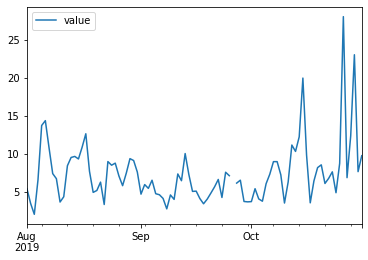

In [19]:
df_hourly.resample('d', how = np.mean).plot(y = 'value', use_index = True)

Here, a trend emerges of a high/low cycle repeating approximately every two weeks. The sudden jumps in late October could be due to the local forest fires leading to increased pollutnat levels in the air. In order to predict values ata  location with no historical data, a history needs to be built from the available data. To do this, for each sensor, the value at a given timestamp for each of the three sensors will be added as features. 

In [20]:
device_locations = df_hourly.groupby('device_ID').mean()
device_locations.reset_index(inplace = True)
#device_locations.head()

In [21]:
distances = []
for target in device_locations.itertuples():
    target_ID = target.device_ID
    target_location = (target.lat, target.lon)
    for neighbor in device_locations.itertuples():
        neighbor_ID = neighbor.device_ID
        neighbor_location = (neighbor.lat, neighbor.lon)
        distance = great_circle(target_location, neighbor_location).miles            
        distances.append ([target_ID, neighbor_ID, distance])
        distance_df = pd.DataFrame(distances)
        distance_df.columns = ['Target','Neighbor','Distance']
    
closest_3 = distance_df.sort_values(['Target','Distance']).groupby('Target').head(4)
closest_3.drop(closest_3.loc[closest_3['Distance']==0].index, inplace=True)
g = closest_3.groupby(['Target']).cumcount().add(1)
C3 = closest_3.set_index(['Target', g]).unstack(fill_value=0).sort_index(axis=1, level=1)
C3.columns = C3.columns.get_level_values(0)
C3.columns =['D1','N1','D2','N2','D3','N3']
C3.reset_index(inplace = True)
C3.head()

#check that C3 and df_model have the same df_clean have the same number of devices
print (len(C3),len(df_hourly.device_ID.unique()))

80 80


Next, for each sensor, the value of the nearest 3 sensors for a given time will be added as features. 

In [22]:
compiled_features = pd.DataFrame({'value':[], 'lat':[], 'lon':[], 'device_ID':[],'VN1':[], 'VN2':[], 'VN3':[]})
#df_clean.reset_index(inplace = True)
for target in C3.itertuples():
    T = target.Target
    N = [target.N1, target.N2, target.N3]
    D = [target.D1, target.D2, target.D3]
    series = df_hourly[df_hourly['device_ID'] == T]
    
    #gather data from nearest 3 sensors
    series_N1 = df_hourly[df_hourly['device_ID'] == target.N1]
    series_N1.rename(columns = {"value":"VN1"}, inplace = True)

    series_N2 = df_hourly[df_hourly['device_ID'] == target.N2]
    series_N2.rename(columns = {"value":"VN2"}, inplace = True)
    
    series_N3 = df_hourly[df_hourly['device_ID'] == target.N3]
    series_N3.rename(columns = {"value":"VN3"}, inplace = True)
    
    #add values to each target series
    features = pd.concat([series, series_N1['VN1'], series_N2['VN2'], series_N3['VN3']], axis=1)
    
    #add each features df to compiled_features df
    compiled_features = pd.concat([compiled_features, features])

//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


NaN values will reduce performance of the prediction models, and some models do not accpets NaN values. But they need to be kept to keep the time series continuous. They will be filled with the mean.  


In [23]:
#first drop the empty rows that were added during the above for loop. These are the rows where deivce_ID is NaN
compiled_features = compiled_features[np.isfinite(compiled_features['device_ID'])]
#fill the remaining na values
compiled_features.fillna(compiled_features.mean(), inplace = True)
print(compiled_features.shape)
compiled_features.head()

(158847, 7)


,value,lat,lon,device_ID,VN1,VN2,VN3
2019-08-02 06:00:00,1.170,37.758148,-122.507665,26131.0,4.260714,29.420714,7.169524
2019-08-03 16:00:00,10.800,37.758148,-122.507665,26131.0,0.630000,21.752000,7.169524
2019-08-03 17:00:00,10.830,37.758148,-122.507665,26131.0,0.610000,22.837857,7.169524
2019-08-06 00:00:00,7.100,37.758148,-122.507665,26131.0,14.102143,20.197143,7.169524
2019-08-08 11:00:00,3.105,37.758148,-122.507665,26131.0,7.555385,25.160769,7.169524


After adding the corresponding values for the nearest 3 values and dropping NaN values, there are 130,031 hourly average data points to build the model from. Up until this point, we needed deivce_ID, lat and long features in order to relate each sensor to it's nearest neighbor. These features are not strongly corellated to the Y value ("value"), as they are constant for each device. However, a heat map will be plotted to see how each of the features correlate with each other; specifically, the target feature "value".

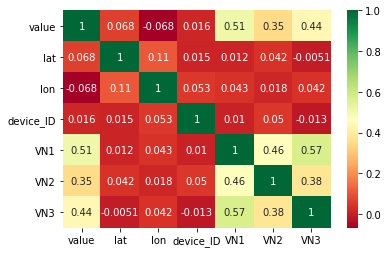

In [24]:
hm=sns.heatmap(compiled_features.corr(),annot=True,cmap="RdYlGn")

As suspected, device_ID, latitude and longitude are not corellated with the target values. lat and long will be dropped from the compiled_features df. device_ID will be kept as it will be used as the basis of the traint/test split so that we can visualize the predictions. 

In [25]:
compiled_features.drop(['lat','lon'],axis = 1, inplace = True)

By adding the values for the nearest 3 sensors, location has been incorporated into the features that will be used for the model. What about time? A common way of incorporating time is by adding the observation that corresponds to the previous timesetep for each current observation, also called lag. However, lag will not be added for the value, becuase at the target location, there is no historical data form which to add a lag. A lag will be added for VN 1-3. 

In [26]:
compiled_features['VN1 lag'] = compiled_features['VN1'].shift()
compiled_features['VN2 lag'] = compiled_features['VN2'].shift()
compiled_features['VN3 lag'] = compiled_features['VN3'].shift()
compiled_features.head()

,value,device_ID,VN1,VN2,VN3,VN1 lag,VN2 lag,VN3 lag
2019-08-02 06:00:00,1.170,26131.0,4.260714,29.420714,7.169524,NaN,NaN,NaN
2019-08-03 16:00:00,10.800,26131.0,0.630000,21.752000,7.169524,4.260714,29.420714,7.169524
2019-08-03 17:00:00,10.830,26131.0,0.610000,22.837857,7.169524,0.630000,21.752000,7.169524
2019-08-06 00:00:00,7.100,26131.0,14.102143,20.197143,7.169524,0.610000,22.837857,7.169524
2019-08-08 11:00:00,3.105,26131.0,7.555385,25.160769,7.169524,14.102143,20.197143,7.169524


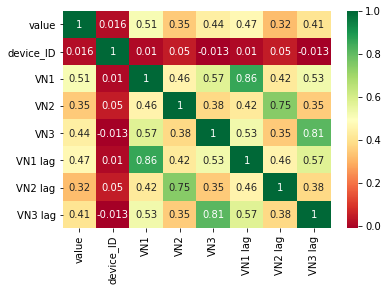

In [27]:
hm=sns.heatmap(compiled_features.corr(),annot=True,cmap="RdYlGn")

After adding a total of 6 features (value of nearest three neighbors and a lag of 1 hour for each), a baseline model can be evaluated and selected prior to tuning hyperparameters. First the features will be split into a training/testing set based on device_ID. That way, predictions for individual time series can be visualized, as opposed to tranining and testing on random values. A standard train/test split is 80/20. Given there 80 individual sensors (and therefore time series), 64 will be used for training and 16 will be used for testing. 

In [28]:
training_devices = compiled_features['device_ID'].unique()[0:62].tolist()
testing_devices = compiled_features['device_ID'].unique()[62:78].tolist()

compiled_training_features = compiled_features[compiled_features['device_ID'].isin(training_devices)].dropna()
compiled_testing_features = compiled_features[compiled_features['device_ID'].isin(testing_devices)].dropna()

print('The training set shape is {}.'.format(compiled_training_features.shape))
print('The testing set shape is {}.'.format(compiled_testing_features.shape))

The training set shape is (124472, 8).
The testing set shape is (32247, 8).


In [29]:
#Now the X features will be (VN1-3 and VN1-3 lag) and Y (value) will be separated.
X_train = compiled_training_features.drop(['value','device_ID'], axis = 1)
X_train.fillna(X_train.mean(), inplace = True)

Y_train = compiled_training_features[['value']]
Y_train.fillna(Y_train.mean(), inplace = True)

X_test = compiled_testing_features.drop(['value','device_ID'], axis = 1)
X_test.fillna(X_test.mean(), inplace = True)

Y_test = compiled_testing_features[['value']]
#IDs in the test set will be saved as they will be used later for visualization 
Y_IDs = compiled_testing_features[['device_ID']]
Y_test.fillna(Y_test.mean, inplace = True)

#Check that train and test sets are the same length and X and Y sets have the same number of features.
print(X_train.shape, Y_train.shape, X_test.shape, Y_test.shape)

(124472, 6) (124472, 1) (32247, 6) (32247, 1)


//anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:6130: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4034: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


In [30]:
#Standard Scaler to transform data.
sc_X = preprocessing.StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.transform(X_test)

Data is highly variable due to seasonality of weather parameters, traffic, wind speed, and many other parameters taht are can be assocaited with different pollutants. KNNRegressor is tested first to capture this variation. 

In [31]:
#import KNeighbors Regressor from sklearn
from sklearn.neighbors import KNeighborsRegressor as KNR
#initiate KNR regressor with 10 neighbors as an arbitrary starting point
regressor = KNR(n_neighbors = 3, metric = 'minkowski', p = 2)
regressor.fit(X_train, Y_train)

#Predict values based on KNR model
Y_hat = regressor.predict(X_test)

#Root Mean Squared Error is a common measure of 
from sklearn.metrics import mean_squared_error 
from math import sqrt

print('RMSE for n_neighbors = 3 is {}.'.format(sqrt(mean_squared_error(Y_test,Y_hat))))

RMSE for n_neighbors = 3 is 10.83061169159173.


Text(0, 0.5, 'RMSE')

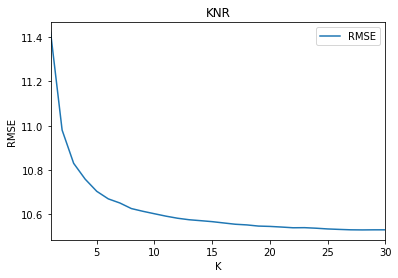

In [32]:
#test K's in a ragne of 1-50
RMSE_K = []
for K in range(30):
    #fit KNR models for a range of K's and fit each model
    regressor_KNR = KNR(n_neighbors = K+1)
    regressor_KNR.fit(X_train, Y_train)
    Y_hat = regressor_KNR.predict(X_test)
    
    #calculate and store each RMSE to plot
    RMSE = sqrt(mean_squared_error(Y_test,Y_hat))
    RMSE_K.append([K+1, RMSE])

#plot K v RMSE_K
RMSE_K = pd.DataFrame(RMSE_K)
RMSE_K.columns = ['K','RMSE']
RMSE_K.plot('K','RMSE')
plt.title('KNR')
plt.ylabel('RMSE')

Using the above graph to select the optimum model, a KNR model with 11 neighbors resulted in a minumum RMSE of 10.59. This values is less than the Y_test standard deviation (11.58). This means the KNR model has some predictive quality. However, there are better models that can be used in scenarios like this with data in this structure. For example, we will repeat the above analysis with an Gradient Boosting model. These will be evaluted on a baseline level (with default parameters) to begin with, only changing n_estimators. This has the added advantage of easily adding prediction intervals

In [33]:
RMSE_GB = []

for n in range(10):
    #fit RFR models for a range of n_estimators and fit each model 
    regressor_GB = GradientBoostingRegressor(n_estimators = (n+1)*10, max_depth = 5)
    regressor_GB.fit(X_train, Y_train.values.ravel())
    Y_hat_GB = regressor_GB.predict(X_test)
    RMSE = sqrt(mean_squared_error(Y_test,Y_hat_GB))
    RMSE_GB.append ([(n+1)*100, RMSE])

Text(0.5, 0, 'n_estimators')

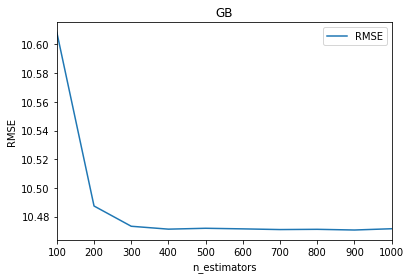

In [34]:
#plot n v RMSE_RFR
RMSE_GB = pd.DataFrame(RMSE_GB)
RMSE_GB.columns = ['n','RMSE']
RMSE_GB.plot('n','RMSE')
plt.title('GB')
plt.ylabel('RMSE')
plt.xlabel('n_estimators')

GBoost perfomred slightly better than KNR, resulting in a lower RMSE (10.48 with n_estimators of 400). It also performed much faster. Provided more time, xGBoost can be further tested and the hyper parameters tuned to minimize RMSE and maximize per
formance. But for now, the predictions are tested plotted against the observations to visualize how the model performed. 

In [35]:
regressor_GB = GradientBoostingRegressor(n_estimators = (n+1)*10, max_depth = 5)
regressor_GB.fit(X_train, Y_train.values.ravel())
Y_hat_GB = regressor_GB.predict(X_test)

In [36]:
predictions_df = pd.DataFrame(pd.concat([Y_IDs, Y_test, pd.DataFrame(Y_hat_GB).set_index(Y_test.index)], axis = 1))
predictions_df.columns = [['device_ID','value','prediction']]
predictions_df.head()

,device_ID,value,prediction
2019-08-01 00:00:00,380072.0,9.686000,10.924097
2019-08-01 01:00:00,380072.0,10.568182,12.993081
2019-08-01 02:00:00,380072.0,11.445000,12.461141
2019-08-01 03:00:00,380072.0,9.278000,11.379113
2019-08-01 04:00:00,380072.0,6.407500,8.474929


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  """Entry point for launching an IPython kernel.


Text(2019-09-28, 30, 'Late October Wild Fires')

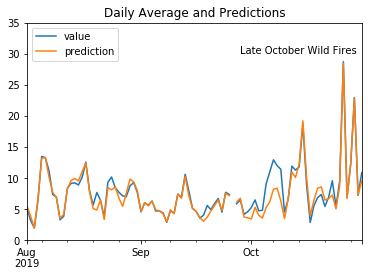

In [37]:
predictions_df.resample('d', how = np.mean).plot(y = ['value','prediction'], use_index = True)
plt.title('Daily Average and Predictions')
plt.legend(('value','prediction'), loc = 'upper left')
plt.ylim(0,35)
plt.annotate('Late October Wild Fires', ('2019-09-28',30))

In [38]:
#What is the RMSE between daily average predictions?
predictions_df_hourly = predictions_df.resample('d', how = np.mean)
predictions_df_hourly.dropna(inplace = True)
daily_RMSE = sqrt(mean_squared_error(predictions_df_hourly['value'],predictions_df_hourly['prediction']))
daily_RMSE
print ('The RMSE of between the daily averages and the dialy average predictions is {:.2f}. This is much better than the RMSE measured for the hourly predictions. This may be becuase there are some outliers remaining in the data or sporadic hourly variations were missed by the model. Resampling by day greatly mitigates the effect of noise.'.format(daily_RMSE))

The RMSE of between the daily averages and the dialy average predictions is 1.31. This is much better than the RMSE measured for the hourly predictions. This may be becuase there are some outliers remaining in the data or sporadic hourly variations were missed by the model. Resampling by day greatly mitigates the effect of noise.


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  


From the above plot, it is clear that while RMSE for the hourly values may seem relatively high, the daily averages are in reality very close to the measured value. This could be due to the hourly variations which arise from sporadic parameters such as wind speed, wind direction, temperatiure, sun cover and many others that vary from pollutant to pollutant. By plotting the dialy average, the effect of these variations is mitigated, making the daily predictions more accurate. We also see a small gap in the time series in late September which will be discussed later. Now the values for the target locations will be predicted using the nearest three sensors. 

In [39]:
target_neighbors = []
target = [37.76595, -122.39902]
for neighbor in device_locations.itertuples():
        neighbor_ID = neighbor.device_ID
        neighbor_location = (neighbor.lat, neighbor.lon)
        distance = great_circle(target_location, neighbor_location).miles            
        target_neighbors.append ([neighbor_ID, distance])
        
target_neighbors = pd.DataFrame(target_neighbors)
target_neighbors.columns = ['Neighbor','Distance']
target_neighbors.sort_values('Distance')
C3 = target_neighbors.Neighbor[1:4].tolist()

In [40]:
print('The 3 sensors nearest to the target location are {}.'.format(C3))

The 3 sensors nearest to the target location are [34530.0, 54991.0, 58501.0].


In [41]:
#create empty df to store values from nearest 3 neighbors
neighbors = pd.DataFrame({'VN1':[], 'VN2':[], 'VN3':[]})
   
#gather data from nearest 3 sensors
series_N1 = df_hourly[df_hourly['device_ID'] == 34530.0]
series_N1.rename(columns = {"value":"VN1"}, inplace = True)

series_N2 = df_hourly[df_hourly['device_ID'] == 54991.0]
series_N2.rename(columns = {"value":"VN2"}, inplace = True)
    
series_N3 = df_hourly[df_hourly['device_ID'] == 58501.0]
series_N3.rename(columns = {"value":"VN3"}, inplace = True)
    
#compile values in one df and add lag
neighbors = pd.concat([series_N1['VN1'], series_N2['VN2'], series_N3['VN3']], axis = 1)
neighbors['VN1 lag'] = neighbors['VN1'].shift()
neighbors['VN2 lag'] = neighbors['VN2'].shift()
neighbors['VN3 lag'] = neighbors['VN3'].shift()
neighbors.fillna(mean, inplace = True)

//anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


In [42]:
#save index to add in later 
index = neighbors.index

In [43]:
#Standard Scaler to transform data.
sc_X = preprocessing.StandardScaler()
neighbors = sc_X.fit_transform(neighbors)

#use previously built model to predict values for the target location 
target_hat_GB = regressor_GB.predict(neighbors)
target_hat_df = pd.DataFrame(target_hat_GB)
target_hat_df.set_index(index, inplace = True)
target_hat_df.columns =['value']
target_hat_df.head()

,value
2019-08-01 00:00:00,11.003701
2019-08-01 01:00:00,10.540173
2019-08-01 02:00:00,11.305841
2019-08-01 03:00:00,8.864050
2019-08-01 04:00:00,6.106051


Text(0, 0.5, 'Prediction')

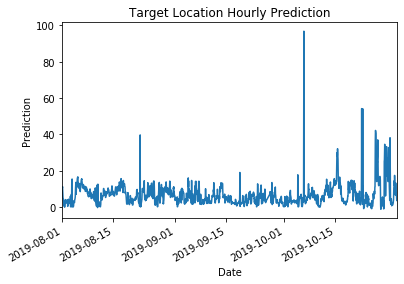

In [44]:
target_hat_df.plot(y = 'value', use_index = True, legend = False)
plt.title('Target Location Hourly Prediction')
plt.xlabel('Date')
plt.ylabel('Prediction')

The challegne specifically requests daily average predcitions for the target location during two stretches of time; 09/23-29 and 10/23-29. The houry prediction df is resampled for daily averages. 

In [45]:
target_hat_daily_df = target_hat_df.resample('d', how = np.mean)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  """Entry point for launching an IPython kernel.


Text(0, 0.5, 'Value')

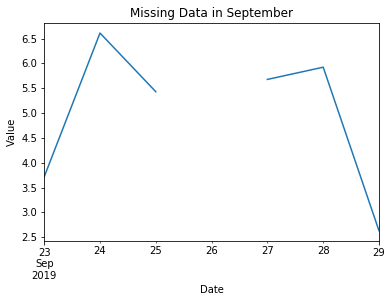

In [46]:
target_hat_daily_df.loc['2019-09-23':'2019-09-29'].plot(y = 'value',use_index = True, legend = False)
plt.title('Missing Data in September')
plt.xlabel('Date')
plt.ylabel('Value')

There are missing data points from 09/26. As this is missing data for only one day, the simplest way to impute would be to replace the missing values with a rolling daily mean from the hourly predictions (pd.rolling(24).mean())

Text(0, 0.5, 'Value')

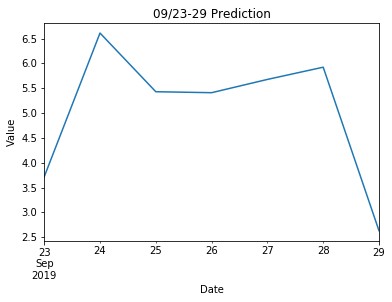

In [47]:
target_hat_daily_df.loc['2019-09-26'] = target_hat_daily_df.rolling(28).mean().loc['2019-09-25']
target_hat_daily_df.loc['2019-09-23':'2019-09-29'].plot(y = 'value',use_index = True, legend = False)
plt.title('09/23-29 Prediction')
plt.xlabel('Date')
plt.ylabel('Value')

Next, the October daily prediction is plotted.

Text(0, 0.5, 'Value')

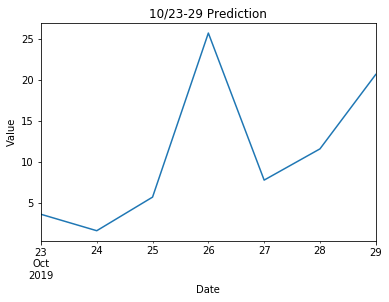

In [48]:
target_hat_daily_df.loc['2019-10-23':'2019-10-29'].plot(y = 'value',use_index = True, legend = False)
plt.title('10/23-29 Prediction')
plt.xlabel('Date')
plt.ylabel('Value')

Finally, the challenge asks for hourly average predictions of 09/23.

Text(2019-09-23 08:00:00, 4, 'Low Traffic Time')

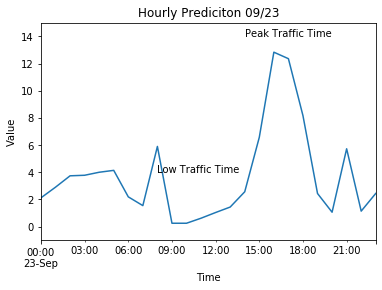

In [49]:
target_hat_df.loc['2019-09-23'].plot(y = 'value',use_index = True, legend = False)
plt.title('Hourly Prediciton 09/23')
plt.ylabel('Value')
plt.xlabel('Time')
plt.ylim(-1,15)
plt.annotate('Peak Traffic Time', ('2019-09-23 14:30:00',14))
plt.annotate('Low Traffic Time', ('2019-09-23 08:00:00',4))

Uncertainty is added using to the predicitons using the quantile method. A GBregressor is resued, but the loss parameter is changed to "quantile" and the alpha values are set to a lower and upper value respectively. Here, a lower and an upper model are trained and fitted. The lower and upper model predictions are then added to the predictions_df, and plotted for visualzation. The mid predictions in the model that has already been trained.

In [50]:
# Each model has to be separate
#lower Model
lower_model = GradientBoostingRegressor(loss="quantile", alpha=0.15, n_estimators=400, max_depth=5)
#The mid model will aldready trained.
#upper model
upper_model = GradientBoostingRegressor(loss="quantile", alpha=0.85, n_estimators=400, max_depth=5)

In [51]:
#Train the lower and upper models
lower_model.fit(X_train, Y_train.values.ravel())
upper_model.fit(X_train, Y_train.values.ravel())

GradientBoostingRegressor(alpha=0.85, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='quantile', max_depth=5,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=400,
                          n_iter_no_change=None, presort='auto',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

In [52]:
#Fit the lower and upper models
lower_pred = lower_model.predict(neighbors)
upper_pred = upper_model.predict(neighbors)

#add to target_hat_df
lower_pred = pd.DataFrame(lower_pred).set_index(index)
upper_pred = pd.DataFrame(upper_pred).set_index(index)
pred_df = pd.concat([target_hat_df, lower_pred, upper_pred], axis = 1)
pred_df.columns = ['prediction','lower','upper']
pred_df.head()


,prediction,lower,upper
2019-08-01 00:00:00,11.003701,7.997887,12.033257
2019-08-01 01:00:00,10.540173,7.591211,12.303564
2019-08-01 02:00:00,11.305841,7.420560,14.166501
2019-08-01 03:00:00,8.864050,5.844420,10.274245
2019-08-01 04:00:00,6.106051,3.837984,7.328210


//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: FutureWarning: how in .resample() is deprecated
the new syntax is .resample(...)..apply(<func>)
  """Entry point for launching an IPython kernel.


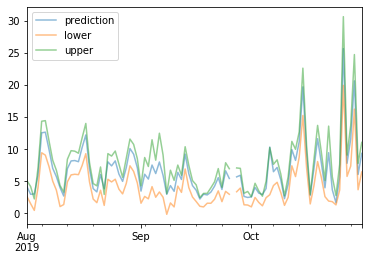

In [53]:
pred_df.resample('d', how = np.mean).plot(y=['prediction','lower','upper'], use_index = True, alpha = 0.5)

### Insights Gained and Assumptions Made During this Exploratory Data Analysis
#### Insights
1. The sensor_df data set contained pollutant time series of 112 sensors. In order the verify that these sensors were statioanry for the length of the sampling period, they lat/lon coordinates were visualized. Of those with non-constant coordinates, the differences only amounted to several feet. So these deicrepancies were neglected.
2. Upon mapping each sensor and its magnitude, several oultiers were potentillay identified. For each sensor, outlying values (threshold = mean + std) were imputed with the rolling average. 
3. By plotting the daily average for all the sensors, the overall trend in the SF Peninsula was seen. There is a cylicla high/low pattern repeating approximately every 2 weeks. There were 2 suden jumps in pollutant value in late October. These could potentially be due to the wild fires that burned in Northern California during this time.

#### Data Pipeline
To prepare the data structure for the model, the following data processes were applied to the data:
1. Outlying values were imputed with the rolling mean. The threshold for outliers was defined as mean+stdev. The standard practice is mean + 3stdev. However, the outliers were so high that they skewed the data, and 1 stdev was selected to more closely capture the trend.
2. Sensors with missing data sets (<1656 hourly data points) were dropped from the data. These missing data could have been imputed, much like the outliers. However, for simplicity and because there was already sufficient complete data, this was not done. 
3. Given the lack of features in this data set, features had to be added to each observation. Location and proximity to other sensors was accounted for by adding the values for the nearest three neighboring sensors. 
4. Fnally, the temporal trend was incorporated by adding a lag feature for each of the nearest value features. This way, time could be incorporated into the model.  
5. A heat map was generated to select which features are most strongly corellated with the target value. device_ID, lat and long were dropped.
6. The data set was split into X and y data sets. X features were neareast value 1-3 and nearset value lag 1-3. Y was the value. 
7. The X and Y data sets were split into training and testing sets (80/20) by device_ID. StandardScaler was applied to X_train and X_test data sets.

#### The Model
1. Two of the models evaluated are shown in this notebook. K Nearest Neighbor Regressor (KNR) and GBoost Regressor (GB). The Root Mean Squared Error (RMSE) of predictions output by the KNR regressor was minimized (~10.59) with 11 neighbors. This RMSE is less than the standard deviation of the test set. XGB did not show significant improvement, reaching a RMSE of 10.48 with n_estimators = 400. However, this model converged much more quickly than KNR, so it was selected for furhter evaluation. 
2. While this RMSE may seem high, this is due to the high hourly variability of the data and the lack of features (discussed furhter in improvements). However, by plitting the daily average, it is clear that the model is actually effective at predicting the daily pollutant value for the SF peninsula as a whole. This may be becasue the hourly variations are mitigated, leading to smoothing of the curve. 
3. For the target location, a set of 6 features was generated for each hourly record. The 6 features include again, the values of the nearest 3 sensors and a 1 hour lag. This data set was passed through the previously selected XGBoost Model, and predictions were plotted.

#### Results
1. Daily predictions of 09/23-29 was plotted and it was determined that there was missing data for 09/26. This missing values was imputed with the rolling mean. This could have also been acheived with a time forecast using ARIMA and RNNs. However, seeing as how there was only a small gap in the data and that data after the gap was available, using these robust methods may have been excessive and out of scope for this challenge. 
2. Daily predictions 0f 10/23-10/29 were plotted. The values in this date range are generally higher than the rest of the time series. In fact, it corresponds to the high spikes seen previoulsy in daily average plotted for all sensors. This could be due to the wild fires that burned in Northern California during this time.
3. Hourly predictions for 09/23 were plotted. There is a splike around 18:00. This corresponds with "rush hour" and people leaving from work as well as peak traffic times. This is likely to contribute to elevated air pollution. Likewuse, the hourly low is during the midde of the workday.

#### Improvements
The lack of features in this data set was compensated for via feature engineering and the addition of nearest neighbor values. However, there are many useful features that could have been included to strengthen the model. 
1. weather conditions not limited to wind direction, wind speed, cloud cover, temperature and percipitation are strongly tied with atmospheric conditions and therefore pollutant concentrations, 
2. heavy traffic can elevate air pollution from emissions. This can even be granularized by classifying which streets are more heavily trafficked.
3. oither pollutants can be a strong predictor to one another as in some cases, pollutants can be tracked by their transformation products,
4. a 3D model can be built if elevation data of each sensor is available. This would be a valualbe feature addition,
5. architectural properties such as building height can also affect air flow paths and the pollutnants carried with it. 
6. Provided more time and more features, more models could be tested and hyper parameters tuned. However, since daily predictions were quite accurate, this may be out of scope.